In [26]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
!pip install matplotlib numpy


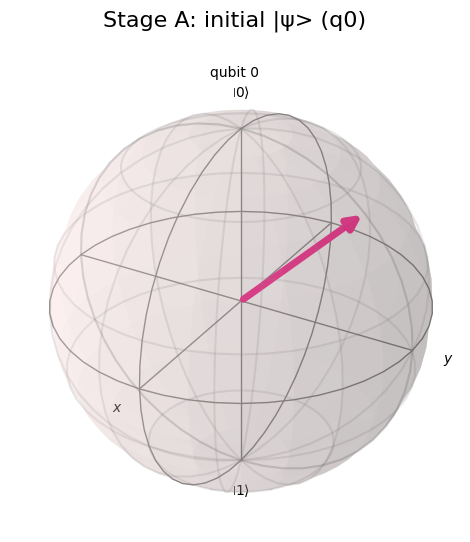

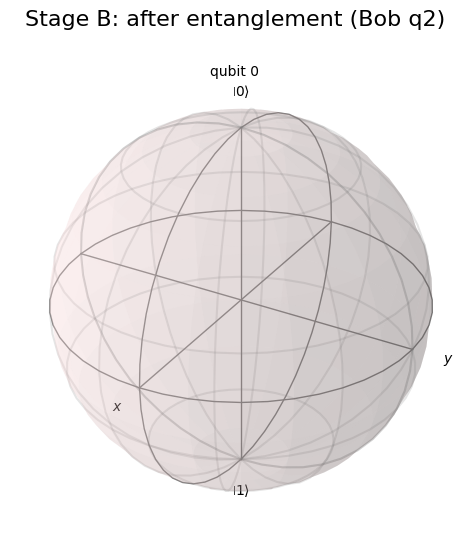

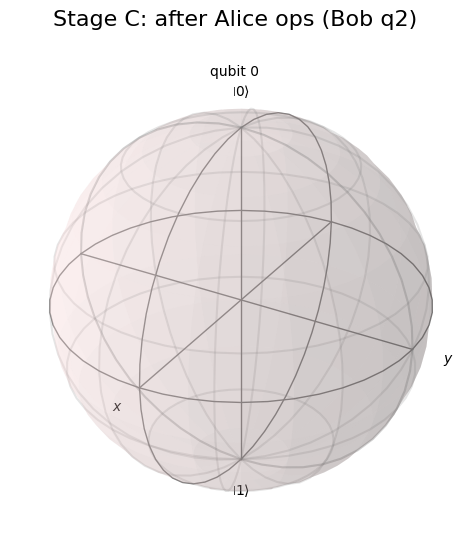

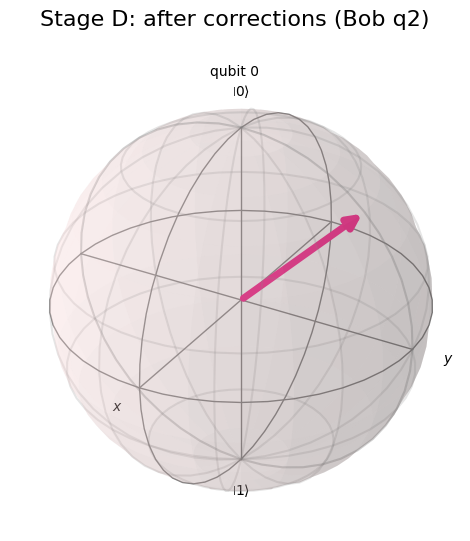

AttributeError: 'InstructionSet' object has no attribute 'c_if'

In [27]:
# Quantum Teleportation – Fixed draw() usage + all tasks (Colab, Qiskit 2.x)
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, state_fidelity
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------
def build_coherent_teleport(theta, phi, save_state=True):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    qc.h(1); qc.cx(1, 2)
    qc.cx(0, 1); qc.h(0)
    qc.cx(1, 2); qc.cz(0, 2)
    if save_state:
        qc.save_statevector()
    return qc

def robust_get_statevector(result, compiled):
    try:
        sv = result.get_statevector(compiled)
        return Statevector(sv)
    except Exception:
        pass
    try:
        data0 = result.data(0)
        if "statevector" in data0:
            return Statevector(data0["statevector"])
        for v in data0.values():
            arr = np.asarray(v)
            if arr.ndim == 1 and arr.size in (2,4,8,16,32,64,128):
                return Statevector(arr)
    except Exception:
        pass
    raise RuntimeError("Unable to extract statevector from result for this Aer version.")

# ----------------------------
# Simulators and noise
# ----------------------------
sim_ideal = AerSimulator()
noise = NoiseModel()
noise.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ["u3","u2","u1"])
noise.add_all_qubit_quantum_error(amplitude_damping_error(0.02), ["u3","u2","u1"])
sim_noisy = AerSimulator(noise_model=noise)

# ----------------------------
# TASK 1 & 4: Snapshots for a demo (theta, phi)
# ----------------------------
theta_demo, phi_demo = np.pi/4, np.pi/2

qc_A = QuantumCircuit(3)
qc_A.ry(theta_demo, 0); qc_A.rz(phi_demo, 0)
sv_A = Statevector.from_instruction(qc_A)
display(plot_bloch_multivector(partial_trace(sv_A, [1,2]), title="Stage A: initial |ψ> (q0)"))

qc_B = QuantumCircuit(3)
qc_B.ry(theta_demo, 0); qc_B.rz(phi_demo, 0)
qc_B.h(1); qc_B.cx(1, 2)
sv_B = Statevector.from_instruction(qc_B)
display(plot_bloch_multivector(partial_trace(sv_B, [0,1]), title="Stage B: after entanglement (Bob q2)"))

qc_C = QuantumCircuit(3)
qc_C.ry(theta_demo,0); qc_C.rz(phi_demo,0)
qc_C.h(1); qc_C.cx(1,2)
qc_C.cx(0,1); qc_C.h(0)
sv_C = Statevector.from_instruction(qc_C)
display(plot_bloch_multivector(partial_trace(sv_C, [0,1]), title="Stage C: after Alice ops (Bob q2)"))

qc_D = QuantumCircuit(3)
qc_D.ry(theta_demo,0); qc_D.rz(phi_demo,0)
qc_D.h(1); qc_D.cx(1,2)
qc_D.cx(0,1); qc_D.h(0)
qc_D.cx(1,2); qc_D.cz(0,2)
sv_D = Statevector.from_instruction(qc_D)
display(plot_bloch_multivector(partial_trace(sv_D, [0,1]), title="Stage D: after corrections (Bob q2)"))

# ----------------------------
# TASK 2: Classical measurement demo (fixed draw usage)
# ----------------------------
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(2, name='c')   # two bits to store measurements of q0,q1
qc_meas = QuantumCircuit(qr, cr)

qc_meas.ry(theta_demo, qr[0]); qc_meas.rz(phi_demo, qr[0])
qc_meas.h(qr[1]); qc_meas.cx(qr[1], qr[2])
qc_meas.cx(qr[0], qr[1]); qc_meas.h(qr[0])

qc_meas.measure(qr[0], cr[0])
qc_meas.measure(qr[1], cr[1])

# Apply corrections by conditioning on the whole ClassicalRegister integer value
qc_meas.x(qr[2]).c_if(cr, 1)   # if cr == 01 (decimal 1) -> X
qc_meas.z(qr[2]).c_if(cr, 2)   # if cr == 10 (decimal 2) -> Z
qc_meas.z(qr[2]).c_if(cr, 3)   # if cr == 11 (decimal 3) -> Z
qc_meas.x(qr[2]).c_if(cr, 3)   # if cr == 11 (decimal 3) -> X

# draw the circuit and add a title via the Matplotlib figure
fig = qc_meas.draw(output='mpl', fold=100, scale=1.0)
fig.suptitle("Measured teleportation with .c_if()", fontsize=12)
display(fig)

# simulate measured circuit (qasm) to show counts
compiled_meas = transpile(qc_meas, AerSimulator())
res_meas = AerSimulator().run(compiled_meas, shots=1024).result()
counts = res_meas.get_counts()
display(plot_histogram(counts, title="Measurement outcomes (measured teleport)"))

# ----------------------------
# TASK 3 & 5: Fidelity analysis across many random states (ideal vs noisy)
# ----------------------------
def fidelity_for(theta, phi, simulator):
    qc = build_coherent_teleport(theta, phi, save_state=True)
    compiled = transpile(qc, simulator)
    res = simulator.run(compiled).result()
    sv_final = robust_get_statevector(res, compiled)
    qc_init3 = QuantumCircuit(3); qc_init3.ry(theta,0); qc_init3.rz(phi,0)
    sv_init3 = Statevector.from_instruction(qc_init3)
    rho_bob = partial_trace(sv_final, [0,1])
    rho_init = partial_trace(sv_init3, [1,2])
    return float(state_fidelity(DensityMatrix(rho_init), DensityMatrix(rho_bob)))

n_samples = 15
thetas = np.random.uniform(0, np.pi, n_samples)
phis = np.random.uniform(0, 2*np.pi, n_samples)

f_ideal = []
f_noisy = []
print("Running fidelity samples (ideal & noisy). This may take a few seconds...")
for t,p in zip(thetas, phis):
    f_ideal.append(fidelity_for(t, p, sim_ideal))
    f_noisy.append(fidelity_for(t, p, sim_noisy))

plt.figure(figsize=(8,4))
plt.plot(range(n_samples), f_ideal, "o-", label="Ideal")
plt.plot(range(n_samples), f_noisy, "s--", label="Noisy (depol+amp-damp)")
plt.xlabel("Sample #"); plt.ylabel("Fidelity"); plt.ylim(0,1.05)
plt.grid(True); plt.legend(); plt.title("Teleportation fidelity: ideal vs noisy")
plt.show()
print(f"Average fidelity (ideal) = {np.mean(f_ideal):.6f}")
print(f"Average fidelity (noisy) = {np.mean(f_noisy):.6f}")

# ----------------------------
# Example: Bob's final Bloch and demo fidelity (demo state)
# ----------------------------
qc_demo = build_coherent_teleport(theta_demo, phi_demo, save_state=True)
res_demo = sim_ideal.run(transpile(qc_demo, sim_ideal)).result()
sv_demo = robust_get_statevector(res_demo, transpile(qc_demo, sim_ideal))
rho_bob_demo = partial_trace(sv_demo, [0,1])
eigvals, eigvecs = np.linalg.eigh(rho_bob_demo.data)
bob_statevec = eigvecs[:, np.argmax(eigvals)]
bob_sv = Statevector(bob_statevec)
fid_demo = state_fidelity(DensityMatrix(partial_trace(Statevector.from_instruction(QuantumCircuit(3).ry(theta_demo,0).rz(phi_demo,0)), [1,2])), DensityMatrix(rho_bob_demo))

print(f"\nDemo fidelity (θ=π/4, φ=π/2) = {fid_demo:.6f}")
display(plot_bloch_multivector(bob_sv, title="Bob's teleported qubit (demo)"))

